# Some fancy Title

## Goal of the project

-) Is there any connection between the location of an AirBnb and Points of interests around it, to the location rating
-) How well can a new location of an AirBnb be predicted (Changed to best location for a tourist)

## Data sets

### listings.csv

Source: http://data.insideairbnb.com/austria/vienna/vienna/2022-09-11/data/listings.csv.gz

This data set contains information about listed AirBnb apartments/rooms in Vienna on the 12th of October 2022. This data set was chosen as it contains location data as well as review ratings for each listed apartment/room.

TODO: Describe data set in more detail

### LANDESGRENZEOGD.csv

Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:LANDESGRENZEOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains geolocation data about the borders of the Austrian federal states. This data set was chosen, to get the exact borders of Vienna. This was especially useful for plotting.

### HALTESTELLEWLOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:HALTESTELLEWLOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains information about each of the public transport stations. This data set was chosen, as the geolocation of each transport station is contained in it.

### WIENTOURISMUSOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&srsName=EPSG:4326&outputFormat=csv&typeName=ogdwien:WIENTOURISMUSOGD

This data set contains information about points of interests for tourists. This data set was chosen, as it is offers a wide variety of different types of locations tourists might be interested in.

TODO: Describe data set in more detail

### district_to_post.csv

Source: Handmade by authors of this project

This data set is basically just a mapping file, which provides a conversion between the postal code and the name of viennese district. This data set was created to join the listings.csv with the other data sets.

### rent_buy.csv
Source: https://www.immopreise.at/Wien/Wohnung/Miete
Handscrapped on 16/12/2022

This data set contains information about the average rent per square metre and average price per square metre of appartements in Vienna. This data set was chosen to provide information about expenses of an AirBnb appartement.

### model_data.csv

Source: Created by this Jupyternotebook

This data set was created out of the ones above and provides the data for the further analysis.

## Imports
The following libraries are used in this project. We also turned of the chained_assignment mode as this would cause problems, we avoid by reassigning the data sets instead of copying.

In [117]:
import pandas as pd
import geopy.distance
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.prepared import prep
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import statsmodels.formula.api as smf
import itertools
pd.options.mode.chained_assignment = None

## Data preprocessing

### Listings

First we load the data set, then we remove the columns we do not need for our analysis. As shown below, the data set contains multiple columns containing information about the host, this is not needed for either of the target questions. Also, the information about the source, when it was scrapped or the url of the listings are dropped. The name and the description of the individual listing are not needed either, as this tasks focus mainly on price and location. Therefore, we only keep the columns that are related to price (`price` and `accommodates` as these will be needed to calculate the price per person) or to the location (`neighbourhood_cleansed` and the geolocation). The other columns that are kept either contain critical information to identify the listing (`ìd`) or provide additional information that might influence the price or the review of a location, without it being dependent on the host.

In [2]:
listings = pd.read_csv("data/listings.csv")
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
listings_cleaned = listings[["id", "neighbourhood_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]

In a next step we clean the `price` column of the $ sign, so we can later on cast it to numeric. Furthermore, we assign the correct data types to the columns.

In [4]:
listings_cleaned['price'] = listings_cleaned['price'].str.extract('(\d+)', expand=False)
listings_cleaned[['price']] = listings_cleaned[['price']].apply(pd.to_numeric)
listings_cleaned.astype({
    "id" : int, "neighbourhood_cleansed": 'category', "latitude": float, "longitude": float, "property_type": 'category',
                             "room_type": 'category', "accommodates": int, "number_of_reviews": int,
                             "review_scores_rating": float, "review_scores_location": float, "reviews_per_month": float
})
listings_cleaned.dtypes

id                          int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                       int64
number_of_reviews           int64
review_scores_rating      float64
review_scores_location    float64
reviews_per_month         float64
dtype: object

Now we can identify all missing values

In [5]:
listings_cleaned.isna().sum()

id                           0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
price                        0
number_of_reviews            0
review_scores_rating      1928
review_scores_location    2024
reviews_per_month         1928
dtype: int64

The number of missing values in columns `review_scores_rating` and `reviews_per_month` suggest, that there is no rating, if there are no reviews, so we check if they are missing always in the same observations, having no reviews.

In [6]:
all(listings_cleaned['review_scores_rating'].isna() == listings_cleaned["reviews_per_month"].isna())

True

In [7]:
all(listings_cleaned['review_scores_rating'].isna() == (listings_cleaned['number_of_reviews'] == 0))

True

As we can see our assumptions is true, if we have no reviews we have a missing value, therefore the data for the two columns are missing at random. Now we first visualize the missing data on a grid, to see if there is some pattern. To do so we first need the `LANDESGRENZEOGD.csv` for the borders of Vienna. We read in the data set and create a Polygon object.

In [8]:
vienna_border = pd.read_csv("data/LANDESGRENZEOGD.csv")

def create_polygon(x):
    x['Polygon'] = shapely.wkt.loads(x['SHAPE'])
    return x

vienna_border = vienna_border.apply(lambda x: create_polygon(x), axis=1)
vienna_border.drop("SHAPE", inplace=True, axis=1)
vienna_border.head()

,FID,OBJECTID,NAME_LANDK,NAME_LANDG,NAME_GEMK,NAME_GEMG,STATAUSTRIA_LAND_KENN,STATAUSTRIA_GEM_KENN,STATAUSTRIA_BEZ_KENN,STATAUSTRIA_BEZ_CODE,FLAECHE,UMFANG,LU_DATE,SE_ANNO_CAD_DATA,Polygon
0,LANDESGRENZEOGD.10881,10881,Wien,WIEN,Stadt Wien,STADT WIEN,9,90001,900,900,4.148711e+08,136475.45,2022-08-26,NaN,POLYGON ((16.437761721115034 48.31681098205513...


As a next step we generate a grid to cover whole of Vienna, so we can more clearly see proximity of data points. This code chunk was heavily inspired by https://www.matecdev.com/posts/shapely-polygon-gridding.html.

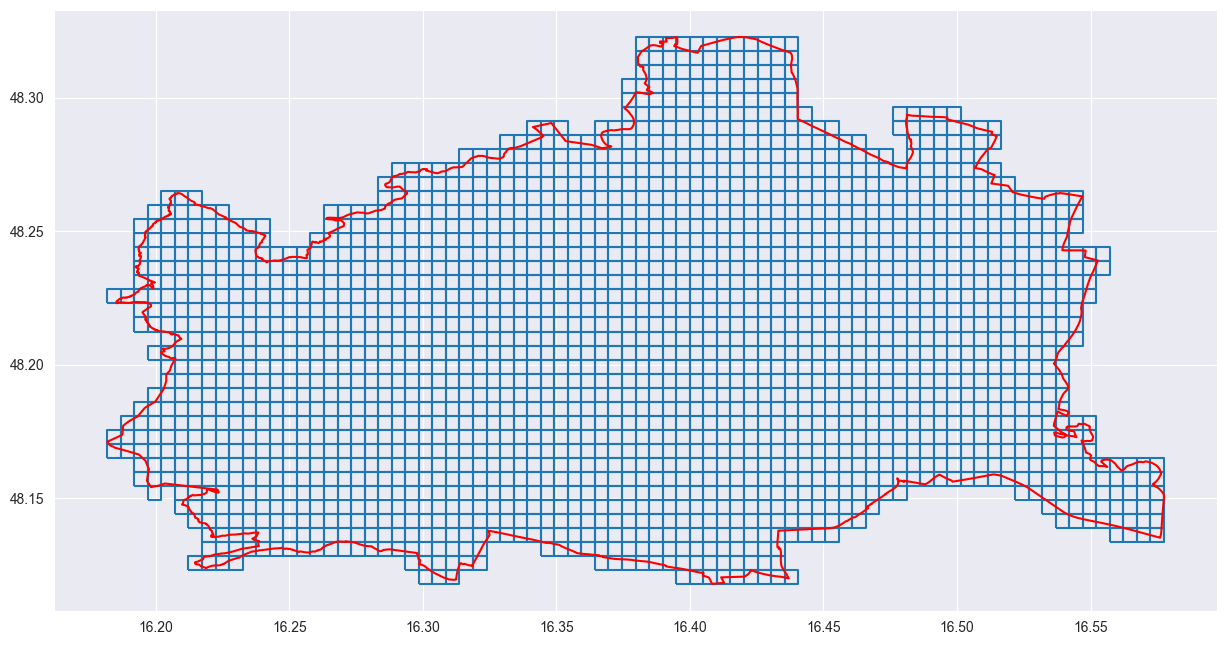

In [9]:
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx) / delta)
    ny = int((maxy - miny) / delta)
    gx, gy = np.linspace(minx, maxx, nx), np.linspace(miny, maxy, ny)
    grid = []
    for i in range(len(gx) - 1):
        for j in range(len(gy) - 1):
            poly_ij = Polygon([[gx[i], gy[j]], [gx[i], gy[j + 1]], [gx[i + 1], gy[j + 1]], [gx[i + 1], gy[j]]])
            grid.append(poly_ij)
    return grid


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid


geom = vienna_border.Polygon[0]
grid = partition(geom, 0.005)

fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
plt.show()

The plot is skewed a little bit, as the grid is defined by geolocation coordinates and the plot ignores the curvature of earth completely. This however does not change the fact, that each grid cell has same amount of square metres.

As a next step, we create a Point object out of the geolocation for each listing. Then we assign each listing the id of the grid cell it lies in. As this takes quite some time to calculate, we save the result in a new file, `grid_listings.csv`, and in a new data frame.

In [10]:
def create_point(x, from_shape=True, column1=None, column2=None):
    if from_shape:
        x['Point'] = shapely.wkt.loads(x['SHAPE'])
    else:
        x['Point'] = Point(x[column1], x[column2])
    return x

listings_cleaned = listings_cleaned.apply(
    lambda x: create_point(x, from_shape=False, column1='longitude', column2='latitude'), axis=1)

def inside_square(x, grid):
    point = x['Point']
    for sq_id, square in enumerate(grid):
        if square.contains(point):
            x['grid_id'] = sq_id
    return x


grid_listings = listings_cleaned.apply(lambda x: inside_square(x, grid), axis=1)

In [11]:
grid_listings.drop(['latitude', 'longitude'], axis=1, inplace=True)
grid_listings.to_csv("data/grid_listings.csv")
grid_listings.head()

,Point,accommodates,grid_id,id,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type
0,POINT (16.42767 48.24262),3,1364.0,15883,Donaustadt,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room
1,POINT (16.37831 48.21924),5,976.0,38768,Leopoldstadt,350,69,Entire rental unit,4.75,4.75,2.50,Entire home/apt
2,POINT (16.32701 48.18434),6,665.0,40625,Rudolfsheim-Fnfhaus,181,145,Entire rental unit,4.59,4.83,1.23,Entire home/apt
3,POINT (16.37161 48.21496),2,943.0,392757,Innere Stadt,100,100,Entire rental unit,4.89,4.64,0.79,Entire home/apt
4,POINT (16.37847 48.21778),3,976.0,51287,Leopoldstadt,347,68,Entire rental unit,4.86,4.65,2.45,Entire home/apt


Now we have all the information we need to plot the listings on the map and marking the grid cells containing listings with missing values. To do so we first get all empty grid cells and the grid cells containing missing values, so we can plot them differently:

In [12]:
empty_sq = []
missing_review_sq = []
missing_loc_review_sq = []
grid_id_list = list(grid_listings['grid_id'])
grid_missing_review_id_list = list(grid_listings[grid_listings['number_of_reviews'] == 0]['grid_id'])
grid_missing_loc_review_id_list = list(grid_listings[grid_listings['review_scores_location'].isna()]['grid_id'])
for idx, sq in enumerate(grid):
    if idx not in grid_id_list:
        empty_sq.append(sq)
    if idx in grid_missing_review_id_list:
        missing_review_sq.append(sq)
    if idx in grid_missing_loc_review_id_list:
        missing_loc_review_sq.append(sq)

In the next code chunk we use that to plot the above selected cells on the map.

In [13]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location')]

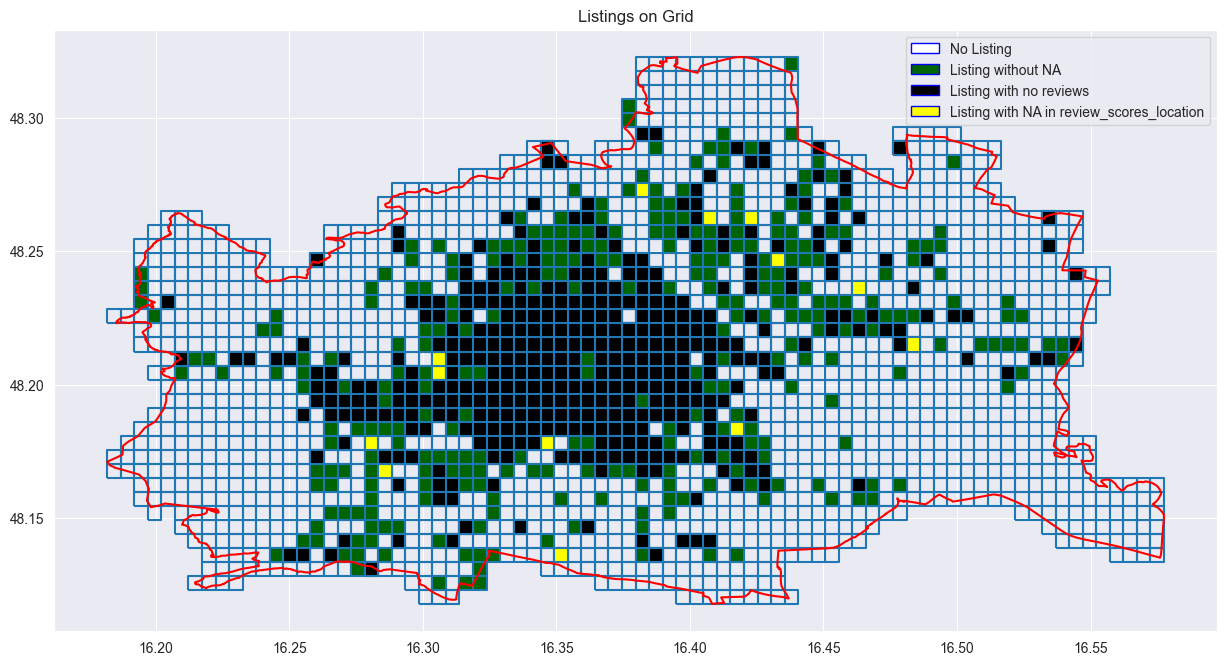

In [14]:
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

This map shows that there is no real pattern for listings not having any reviews. But it seems like most of the `review_scores_location` missing values are due to the number of reviews being zero. So we check this assumption:


In [15]:
len(grid_listings[(grid_listings['number_of_reviews']!=0) & (grid_listings['review_scores_location'].isna())])

96

As we can see only 96 observations have missing values, if there are reviews available. We assume that these are MAR as well, as some people did not rate the location, but left an overall review score. Therefore, as dropping the observations would lose us about a fifth of the available listings and we suspect the data is MAR, we use MICE instead to impute the missing values.

In [16]:
df_mice = grid_listings.filter(['accommodates', 'grid_id', 'id',  'number_of_reviews',
                                'price',  'review_scores_location', 'review_scores_rating','reviews_per_month'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
grid_listings[['review_scores_location', 'review_scores_rating', 'reviews_per_month']] = df_mice_imputed[['review_scores_location', 'review_scores_rating', 'reviews_per_month']]

In [17]:
grid_listings.isna().sum()

Point                      0
accommodates               0
grid_id                   70
id                         0
neighbourhood_cleansed     0
number_of_reviews          0
price                      0
property_type              0
review_scores_location     0
review_scores_rating       0
reviews_per_month          0
room_type                  0
dtype: int64

Above we can see that we have 70 listings that have no `grid_id`, first we check if those are actually the ones outside of Vienna, we do that by plotting again.

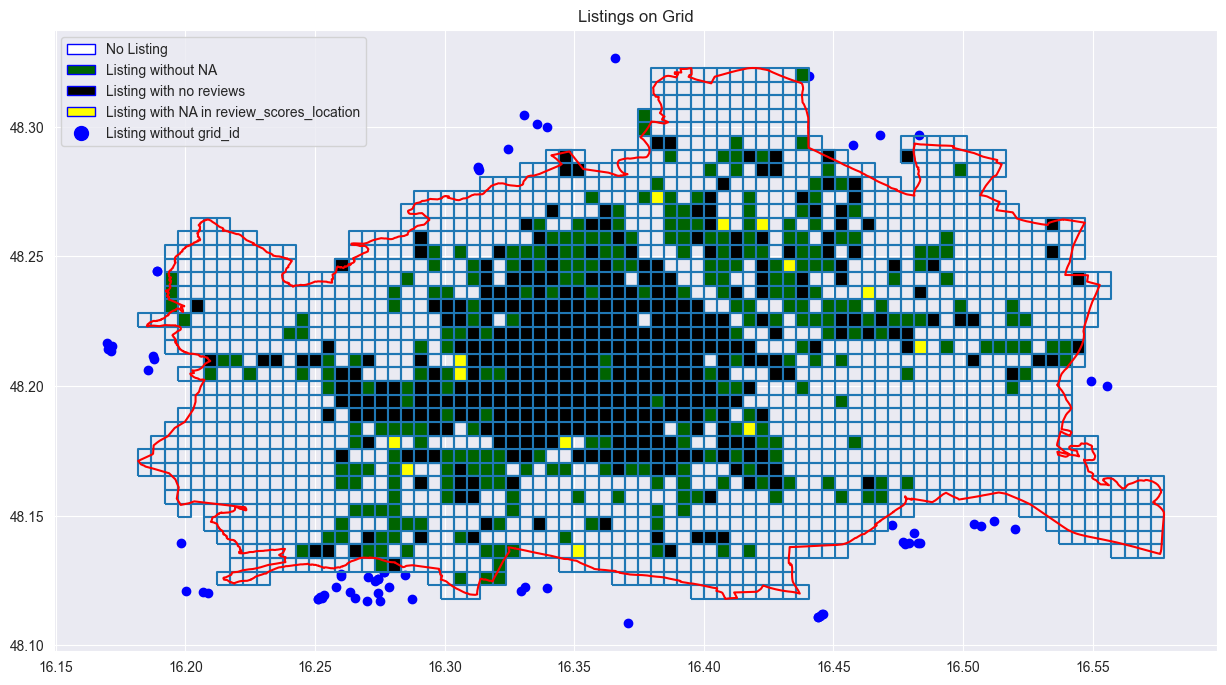

In [18]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location'),
                   Line2D([0], [0], marker='o', color='blue', label='Listing without grid_id',
                      markerfacecolor='blue', markersize=10, ls = '')]
possibly_outside = grid_listings.copy()
possibly_outside.isna().sum()
possibly_outside_points = possibly_outside[possibly_outside['grid_id'].isna()]
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries(possibly_outside_points['Point']).plot(ax=ax, color="blue")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

It is clearly visible, that all those listings are outside of Vienna, as the scope of the project is defined by looking at listings in Vienna, we remove those from the `grid_listings`

In [19]:
grid_listings=grid_listings.dropna()
grid_listings.isna().sum()

Point                     0
accommodates              0
grid_id                   0
id                        0
neighbourhood_cleansed    0
number_of_reviews         0
price                     0
property_type             0
review_scores_location    0
review_scores_rating      0
reviews_per_month         0
room_type                 0
dtype: int64

Now we have cleaned the `grid_listings`. As the price is not really comparable due to different sizes of appartements/rooms, we try to make it more comparable by introducing a new column: `price_per_person`. This way appartements/rooms for more than one person do not have a significantly higher price per default than single person appartements/rooms.

In [20]:
grid_listings['price_per_person'] = grid_listings['price']/grid_listings['accommodates']

We take a look whether this generated any NAs.

In [21]:
grid_listings.isna().sum()

Point                     0
accommodates              0
grid_id                   0
id                        0
neighbourhood_cleansed    0
number_of_reviews         0
price                     0
property_type             0
review_scores_location    0
review_scores_rating      0
reviews_per_month         0
room_type                 0
price_per_person          1
dtype: int64

As this is only one observation, we decided to drop it.

In [22]:
grid_listings.dropna(inplace=True)

As a next step, we want to get the information form the `neighbourhood_cleansed` column, the district of Vienna, into a more convenient format, so it is compatible with the other data sets. For this we first need to fix problems with German Umlaute, to be exact, the district `Rudolfsheim-Fünfhaus`, was not correctly loaded. Therefore, we replace every row containing `Rudolfsheim`, with the correct `Rudolfsheim-Fünfhaus`. Then we use the `district_to_post.csv`, to get the postal code for each district. Now we can drop the merge columns, `neighbourhood_cleansed` from `grid_listings` and `name` from `district_to_post`.

In [23]:
grid_listings.loc[:, 'neighbourhood_cleansed'] = grid_listings.loc[:, 'neighbourhood_cleansed'].apply(
    lambda x: "Rudolfsheim-Fünfhaus" if str(x).__contains__("Rudolfsheim") else x
)
mapping = pd.read_csv("data/district_to_post.csv")
merged = grid_listings.merge(mapping, left_on="neighbourhood_cleansed", right_on="name", how="inner")
merged.head()
merged.drop(["neighbourhood_cleansed", "name"], inplace=True, axis=1)
merged.rename({"name_x": "name"}, inplace=True, axis=1)
grid_listings = merged
grid_listings.head()

,Point,accommodates,grid_id,id,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,price_per_person,post
0,POINT (16.42767 48.24262),3,1364.0,15883,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,36.666667,1220
1,POINT (16.42418 48.23796),4,1324.0,813826,10,82,Entire rental unit,5.00,4.80,0.10,Entire home/apt,20.500000,1220
2,POINT (16.41152 48.23549),3,1246.0,846009,72,60,Entire condo,4.86,4.77,0.61,Entire home/apt,20.000000,1220
3,POINT (16.44955 48.22707),2,1504.0,1384870,92,34,Private room in rental unit,4.59,4.60,0.83,Private room,17.000000,1220
4,POINT (16.51765 48.21659),4,1876.0,3217556,17,76,Entire rental unit,4.65,4.76,0.51,Entire home/apt,19.000000,1220


As the `grid_listings` now has the desired format, we can write it again.

In [24]:
grid_listings.to_csv("data/grid_listings_cleaned.csv")

### Stations

Again we load the data set and create a column with Point objects, so we can determine in which grid cell the public transport station is. Here we use the functions from above to receive the intended result.

In [25]:
stations = pd.read_csv("data/HALTESTELLEWLOGD.csv")
stations = stations.apply(lambda x: create_point(x), axis=1)
stations.drop("SHAPE", inplace=True, axis=1)
grid_stations = stations.apply(lambda x: inside_square(x, grid), axis=1)
grid_stations.head()

,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


The goal with this data set is, that we count the number of transport stations per grid cell, therefore we can drop everything except the `OBJECTID`,`grid_id` and `Point` (which we can use for plotting purposes).

In [26]:
grid_stations = grid_stations[['OBJECTID', 'grid_id', 'Point']]

Now we check whether the data contains NAs or not.

In [27]:
grid_stations.isna().sum()

OBJECTID    0
grid_id     2
Point       0
dtype: int64

We check again whether those two stations are outside of Vienna or not.

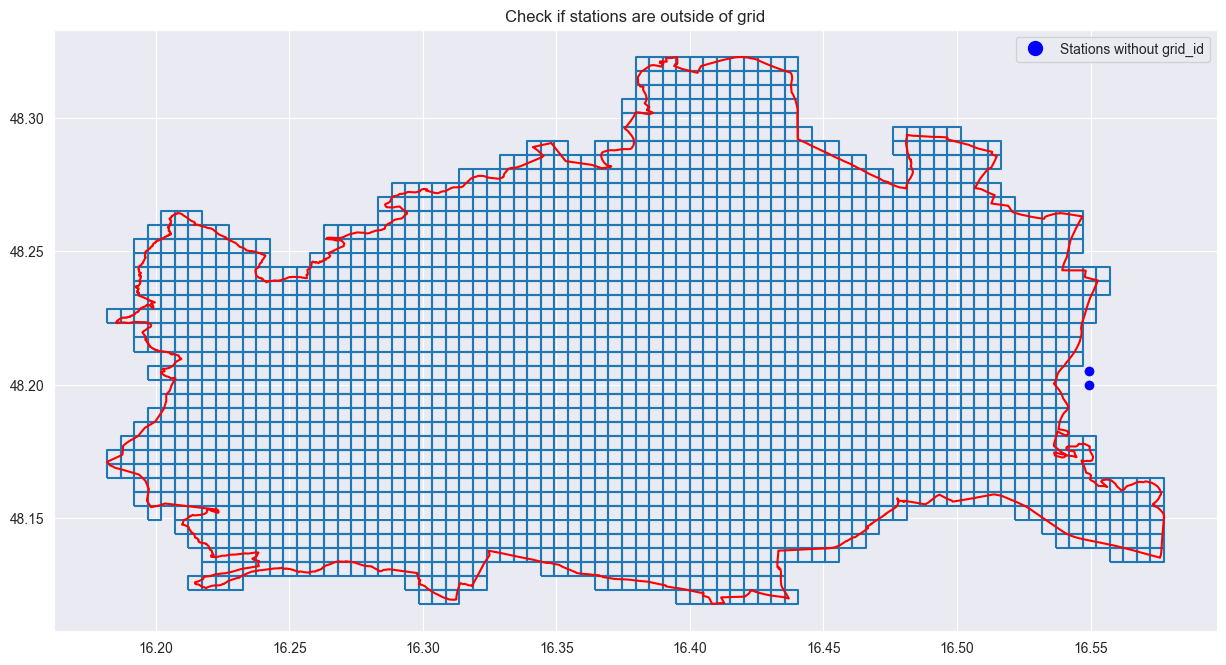

In [28]:
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Stations without grid_id',
                      markerfacecolor='blue', markersize=10, ls = '')]
possibly_outside = grid_stations.copy()
possibly_outside_points = possibly_outside[possibly_outside['grid_id'].isna()]
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries(possibly_outside_points['Point']).plot(ax=ax, color="blue")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Check if stations are outside of grid")
plt.show()

Again our assumption holds true, that those without `grid_id` are outside of Vienna, therefore we can drop them.

In [29]:
grid_stations.dropna(inplace=True)
grid_stations.isna().sum()

OBJECTID    0
grid_id     0
Point       0
dtype: int64

Now we have cleaned the `grid_stations`. We want to use the number of stations per grid cell as information, so we aggregate this first.

In [30]:
model_data_stations = grid_stations.groupby("grid_id").agg(
    number_st=("grid_id", "count"))
model_data_stations.head()

,number_st
grid_id,
29.0,1
33.0,1
52.0,1
53.0,1
71.0,1


### WIENTOURISMUSOGD.csv

We only select the relevant columns out of the data set, and we remove everything related to accommodations, meaning hotels, pensions, appartements and seasonal hotels. We do this, because we assume, that tourists are not interested in visiting hotels, when staying in an AirBnb. We are aware that this assumption does not always hold (for example Hotel Sacher is a point of interest for tourists), but in general this is true.

In [31]:
tourism = pd.read_csv("data/WIENTOURISMUSOGD.csv")
toursim_cleaned = tourism[['NAME','POSTALCODE', 'CATEGORY_NAME','SUBCATEGORY_NAME', 'GEOLAT', 'GEOLONG']]
remove_cats = ['Hotel', 'Pension', 'Appartement', 'Saisonhotel']
toursim_cleaned = toursim_cleaned[~toursim_cleaned['SUBCATEGORY_NAME'].isin(remove_cats)]
toursim_cleaned.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029


The next step, as already with the other data sets, is creating a `Point` column and checking within which grid cell each of the data points lies.

In [32]:
toursim_cleaned = toursim_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='GEOLONG', column2='GEOLAT'), axis=1)
grid_tourism = toursim_cleaned.apply(lambda x: inside_square(x, grid), axis=1)
grid_tourism.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG,Point,grid_id
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447,POINT (16.3644467 48.2192221),881
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125,POINT (16.3381246 48.195808),724
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072,POINT (16.4020719 48.2154501),1164
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952,POINT (16.3949522 48.2162356),1125
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029,POINT (16.3980286 48.2167269),1125


Now we check for NAs in this data set.

In [33]:
grid_tourism.isna().sum()

NAME                0
POSTALCODE          0
CATEGORY_NAME       0
SUBCATEGORY_NAME    0
GEOLAT              0
GEOLONG             0
Point               0
grid_id             0
dtype: int64

As we can see there are no NA values, so we can prepare the data set in the way we want. So we aggregate the number of observations per grid cell, as well as the number of unique subcategories per grid cell.

In [34]:
model_data_tsm = grid_tourism.groupby("grid_id").agg(
    number_different_tsm=("SUBCATEGORY_NAME", "nunique"),
    number_tsm=("grid_id", "count"))
model_data_tsm.head()

,number_different_tsm,number_tsm
grid_id,,
33,1,2
53,1,1
125,2,2
176,1,1
234,1,1


Now we can continue with merging the data sets.

### Merging the data sets

First we use the `rent_buy.csv` to add rental and buying information to each listing. We can do this without checking the `rent_buy.csv` for clean data, as we generated the data per hand and know it is clean.

In [35]:
rent_buy = pd.read_csv("data/rent_buy.csv")
grid_listings = grid_listings.merge(rent_buy, on='post', how="left")

As a next step, we merge the three data sets and save it to `model_data.csv`.

In [36]:
model_data = grid_listings.merge(model_data_tsm, on="grid_id").merge(model_data_stations, on="grid_id")
model_data.reset_index(inplace=True)
model_data.to_csv("data/model_data.csv", index=False)
model_data.head()

,index,Point,accommodates,grid_id,id,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,price_per_person,post,avg_rent,avg_buy,number_different_tsm,number_tsm,number_st
0,0,POINT (16.42767 48.24262),3,1364.0,15883,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,36.666667,1220,16.72,6668.69,3,3,1
1,1,POINT (16.42773 48.24256),3,1364.0,12634008,1,110,Room in bed and breakfast,5.00,5.00,0.45,Hotel room,36.666667,1220,16.72,6668.69,3,3,1
2,2,POINT (16.42952 48.23869),3,1364.0,19281153,74,120,Entire rental unit,4.88,4.89,1.19,Entire home/apt,40.000000,1220,16.72,6668.69,3,3,1
3,3,POINT (16.42418 48.23796),4,1324.0,813826,10,82,Entire rental unit,5.00,4.80,0.10,Entire home/apt,20.500000,1220,16.72,6668.69,5,5,2
4,4,POINT (16.42339 48.23837),2,1324.0,4134543,2,40,Entire rental unit,4.50,5.00,0.02,Entire home/apt,20.000000,1220,16.72,6668.69,5,5,2


## Relationship between location rating and collected features

In the next section, we focus on extracting whether our collected data, mainly, the number of tourism spots, the number of unique tourism spots, the average rent, as well as the average buy price and the number of transport stations within a grid effect the locations rating and if so in which way.

The first approach here is taking a look at the correlation:

Text(0.5, 1.0, 'Correlation matrix')

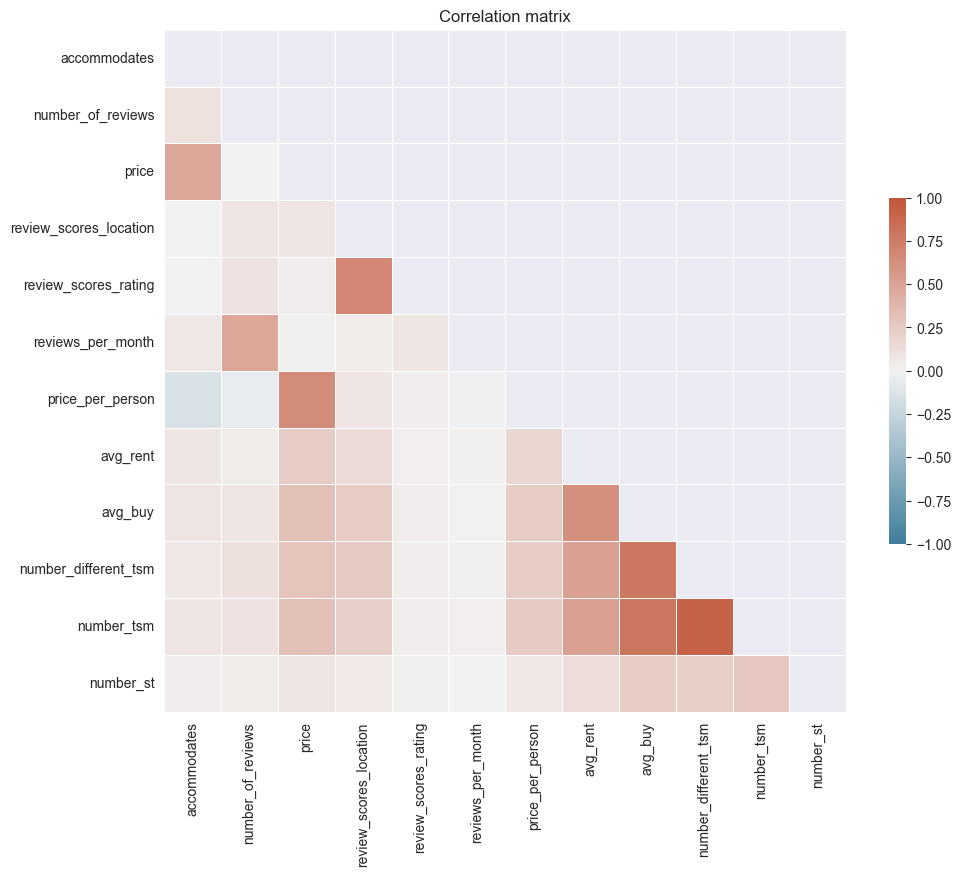

In [37]:
model_data = pd.read_csv('data/model_data.csv')

relevant_features_df = model_data.drop(['index', 'Point', 'id', 'post', 'grid_id'], axis=1)
corr = relevant_features_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")

The column of interest is `review_scores_location`, which does not correlate with any of the columns, except `review_scores_rating`, which is to be expected. If one rates the location with a high score, the overall score is most likely being higher as well.
As correlation only tells us something about the linear relationship, we will take a look at the scatterplot matrix as well.

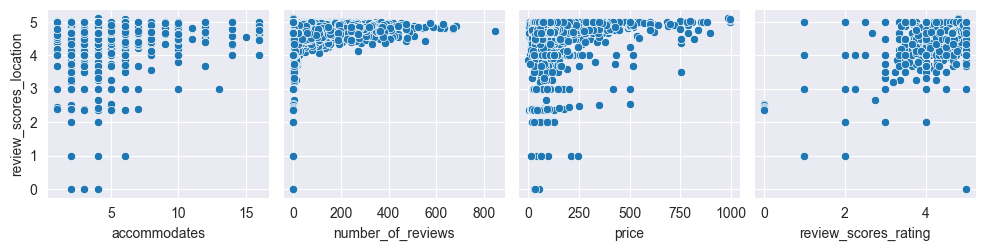

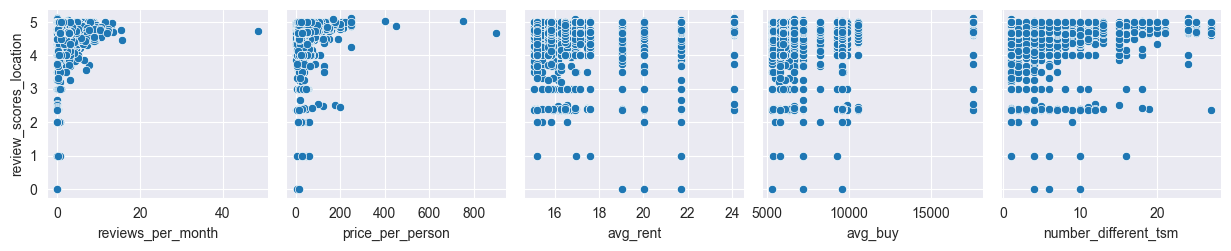

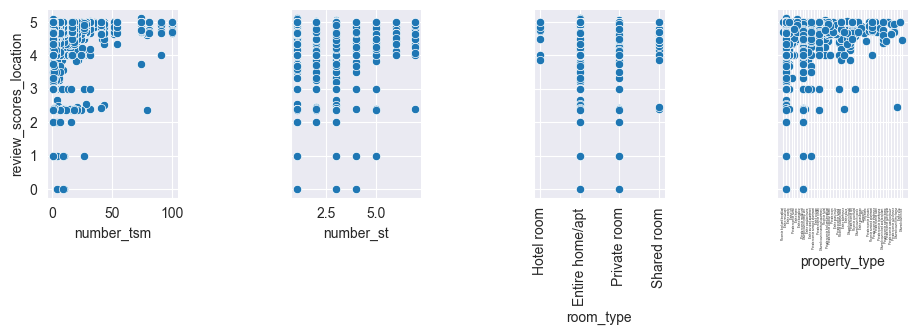

In [38]:
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['accommodates', 'number_of_reviews', 'price', 'review_scores_rating'])
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['reviews_per_month', 'price_per_person', 'avg_rent', 'avg_buy', 'number_different_tsm'])
grid = sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_tsm', 'number_st', 'room_type', 'property_type'])
grid.axes.flat[2].tick_params(axis='x', labelrotation=90)
grid.axes.flat[3].tick_params(axis='x', labelrotation=90, labelsize=2)

The `property_type` has not well readable x-ticks, but this is ignored, as if there would be a pattern visible, we would have taken a closer look at it. In all these plots no clear pattern or relationship between the variables is visible, therefore we will now take a look at the histograms of these variables.

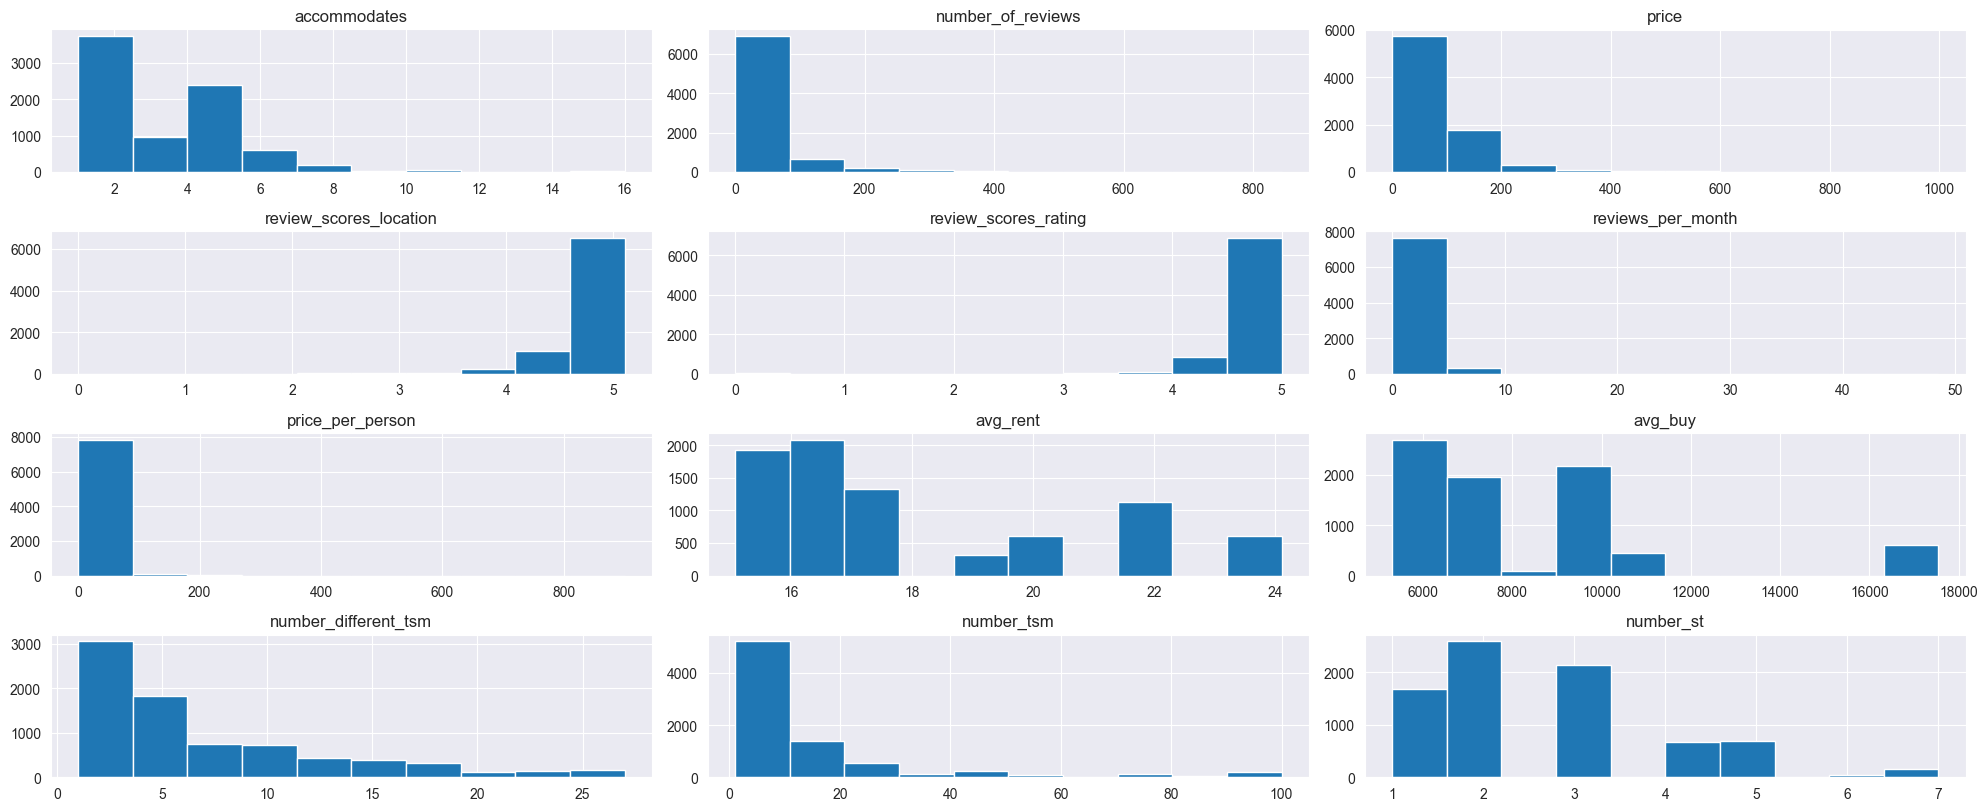

In [39]:
ax_list = relevant_features_df.hist(layout=(5,3), figsize=(20,10))
plt.tight_layout()

Now we take the a closer look at all the right or left skewed features, so we can log transform them, in the hope to get a more linear relationship with the `review_scores_location` variable.

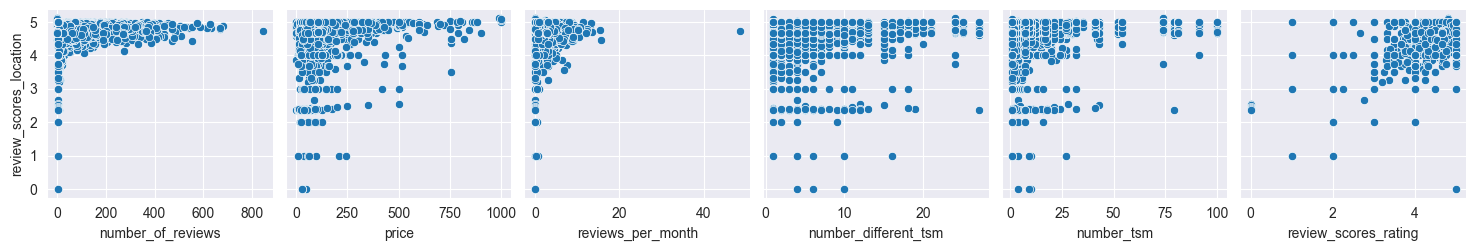

In [40]:
log_df = relevant_features_df[['review_scores_location', 'number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating']]
log_df = log_df.apply(np.log, axis=1)
log_df.review_scores_location = relevant_features_df.review_scores_location
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating'])

After this data exploration, we fit a OLS to describe the relationship. We are using the `stats` version of it, as it allows a summary, that automatically performs significance tests, which give information whether to drop a variable for the model or not. We will use the 5\% significance level for dropping variables.

In [41]:
model = smf.ols(formula="review_scores_location ~ np.log(number_of_reviews, where=(number_of_reviews!=0)) +"
                        "np.log(price, where=(price!=0)) + "
                        "np.log(reviews_per_month) + np.log(number_different_tsm) +"
                        "np.log(number_tsm) + np.log(review_scores_rating, where=(review_scores_rating!=0)) + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.155
Model:                                OLS   Adj. R-squared:                  0.149
Method:                     Least Squares   F-statistic:                     26.32
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):          7.78e-243
Time:                            13:07:32   Log-Likelihood:                -2811.7
No. Observations:                    7967   AIC:                             5735.
Df Residuals:                        7911   BIC:                             6127.
Df Model:                              55                                         
Covariance Type:                nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The adjusted R-squared is really low of the model, therefore we try it without the log transformation.

In [42]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.528
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     161.2
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:07:32   Log-Likelihood:                -487.29
No. Observations:                    7970   AIC:                             1087.
Df Residuals:                        7914   BIC:                             1478.
Df Model:                              55                                         
Covariance Type:                nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

We can see that the model has now a much higher adjusted R-squared. As all the categorical variables (`room_type` and `property_type`) are really insignificant we drop those.

In [43]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     881.7
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:07:32   Log-Likelihood:                -511.20
No. Observations:                    7970   AIC:                             1044.
Df Residuals:                        7959   BIC:                             1121.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

This dramatically decreased our model size, but the adj. R-squared is still the same. Now we drop the other insignificant variables:

In [44]:
model = smf.ols(formula="review_scores_location ~ "
                        "number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     1470.
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:07:32   Log-Likelihood:                -511.63
No. Observations:                    7970   AIC:                             1037.
Df Residuals:                        7963   BIC:                             1086.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

After dropping all the insignificant variables, we have received a small model that has the same adjusted R-squared as the biggest one. Now we check whether the model assumptions are even fulfilled.

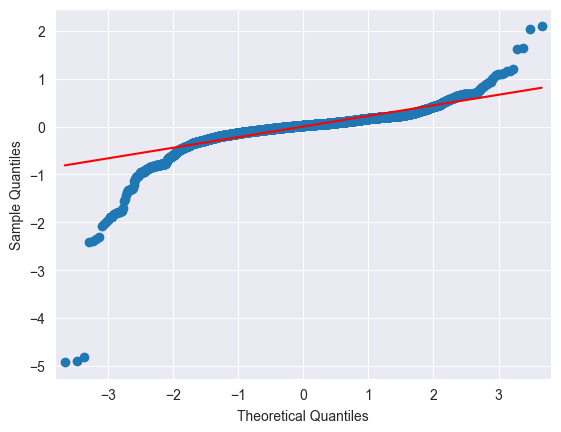

In [45]:
qq = sm.qqplot(model.resid, line='r')

The qq-plot does not look too great, because it has quite heavy tails. There are three points, that we need to check, because those are obviously outliers and we want to know whether they impact the model a lot.

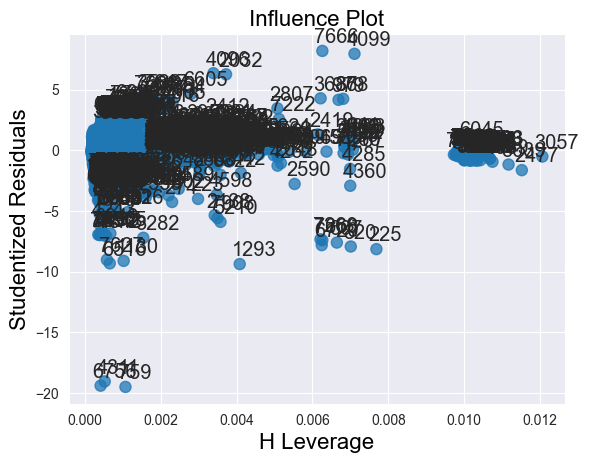

In [46]:
levfig = sm.graphics.influence_plot(model, size=8)

Using the influence plot, we can see that the three outliers before (those with really low studentized residuals) have close to zero impact on our model, so we can just leave them in. Now we can interpret the model:

Obviously, the most important factor that impacts the `review_scores_location` is the `review_scores_rating`, while the other ones have comparatively little impact, most of them even with negative coefficients. Interestingly enough, the number of different tourism points of interest has a positive impact, while the overall number of tourism points of interest has a negative one. The intercept is close to 2.5, which is what one would expect, the high `review_scores_location` are explained by the overall high ratings.

This concludes the answer to the question on how much impact points of interest and additional factors have on the location rating of an AirBnb.

## Predicting best AirBnb location for tourists

The original goal was to predict the best location for a new AirBnb, if you are a host. One of the major factors is the expenses for an AirBnb at a certain location, this information sadly was not available. While one could get the average rent and buying prices per square metre, no information about typical sizes of AirBnbs in square metres per type (or number of accommodates) were available for free. Neither were typical operating costs per district (or more precise) available. Therefore, we followed the data science cycle and went back and looked for questions we could answer with all the data we were able to collect (and was generally available for free).

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [48]:
empty_grid_df = relevant_features_df[["review_scores_rating","number_different_tsm", "number_tsm","number_st", "avg_buy","avg_rent"]]
scaler = StandardScaler()
scaled = scaler.fit_transform(empty_grid_df)
X = scaled[:,1:]
y = scaled[:,0]
r = RandomForestRegressor()
r.fit(X, y)

RandomForestRegressor()

In [49]:
result = r.predict(X)
result

array([ 0.33239109,  0.33239109,  0.33239109, ..., -0.09788179,
       -0.09788179, -0.09788179])

In [50]:
r2_score(y, result)

0.049210767366422825

In [51]:
model_data.sort_values('review_scores_location', ascending=False)

,index,Point,accommodates,grid_id,id,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,price_per_person,post,avg_rent,avg_buy,number_different_tsm,number_tsm,number_st
2551,2551,POINT (16.36878 48.20661),4,909.0,44446828,0,987,Entire rental unit,5.105700,4.799118,-0.019718,Entire home/apt,246.750000,1010,24.10,17548.21,24,74,1
2552,2552,POINT (16.36698 48.20578),4,909.0,44446829,0,987,Entire rental unit,5.105700,4.799118,-0.019718,Entire home/apt,246.750000,1010,24.10,17548.21,24,74,1
2553,2553,POINT (16.36839 48.20714),4,909.0,44446837,0,987,Entire rental unit,5.105700,4.799118,-0.019718,Entire home/apt,246.750000,1010,24.10,17548.21,24,74,1
7501,7501,POINT (16.20275 48.22896),6,53.0,9554243,0,998,Entire home,5.090599,4.797317,0.020351,Entire home/apt,166.333333,1140,16.94,6646.13,1,1,1
1090,1090,POINT (16.38946368191045 48.22199747572711),6,1049.0,696169867795419147,0,999,Room in hotel,5.047675,4.791728,2.516149,Private room,166.500000,1020,21.69,7153.37,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6720,6720,POINT (16.3448 48.21318),2,788.0,24448423,1,10,Private room in rental unit,1.000000,1.000000,0.020000,Private room,5.000000,1080,17.58,9281.75,6,9,4
820,820,POINT (16.384789883306492 48.21578784424917),2,1048.0,640255342365325536,1,95,Entire rental unit,1.000000,1.000000,0.320000,Entire home/apt,47.500000,1020,21.69,7153.37,10,10,1
759,759,POINT (16.38569 48.21452),3,1048.0,12715945,1,50,Private room in rental unit,0.000000,5.000000,0.010000,Private room,16.666667,1020,21.69,7153.37,10,10,1
4311,4311,POINT (16.37392 48.22883),4,946.0,6965960,1,29,Entire rental unit,0.000000,5.000000,0.010000,Entire home/apt,7.250000,1200,19.02,5303.23,4,4,3


In [52]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

The column of interest is `review_scores_location`, which does not correlate with any of the columns, except `review_scores_rating`, which is to be expected. If one rates the location with a high score, the overall score is most likely being higher as well.
As correlation only tells us something about the linear relationship, we will take a look at the scatterplot matrix as well.

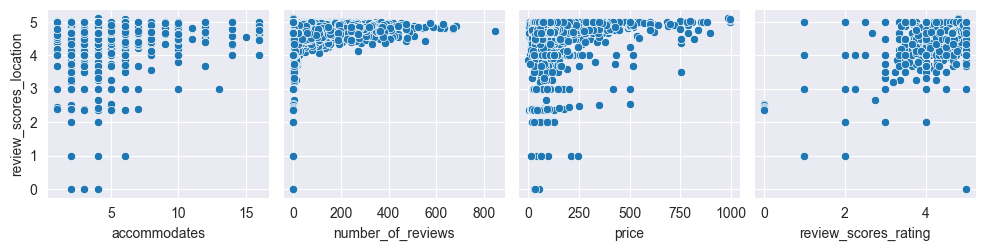

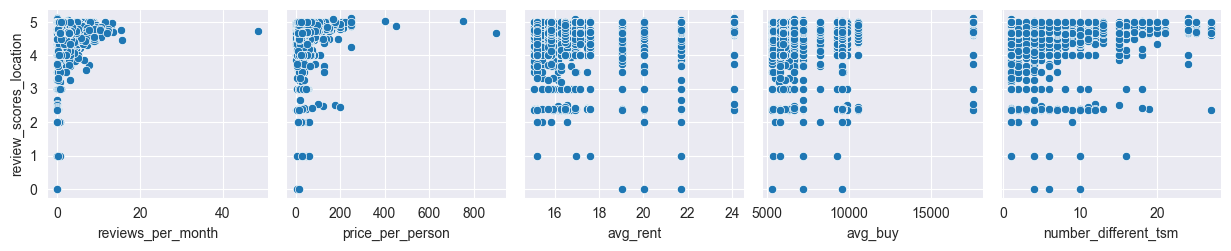

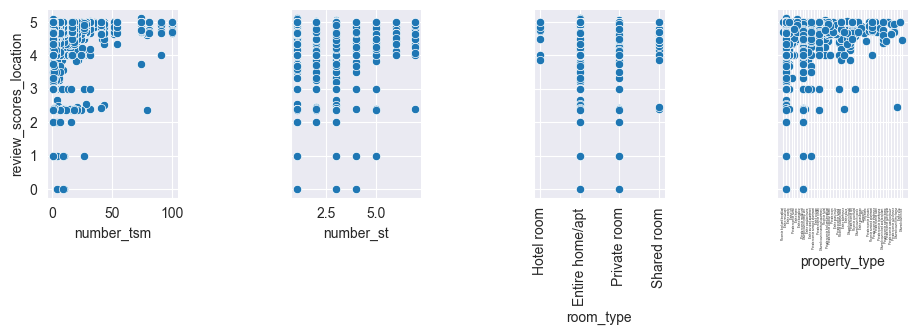

In [53]:
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['accommodates', 'number_of_reviews', 'price', 'review_scores_rating'])
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['reviews_per_month', 'price_per_person', 'avg_rent', 'avg_buy', 'number_different_tsm'])
grid = sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_tsm', 'number_st', 'room_type', 'property_type'])
grid.axes.flat[2].tick_params(axis='x', labelrotation=90)
grid.axes.flat[3].tick_params(axis='x', labelrotation=90, labelsize=2)

The `property_type` has not well readable x-ticks, but this is ignored, as if there would be a pattern visible, we would have taken a closer look at it. In all these plots no clear pattern or relationship between the variables is visible, therefore we will now take a look at the histograms of these variables.

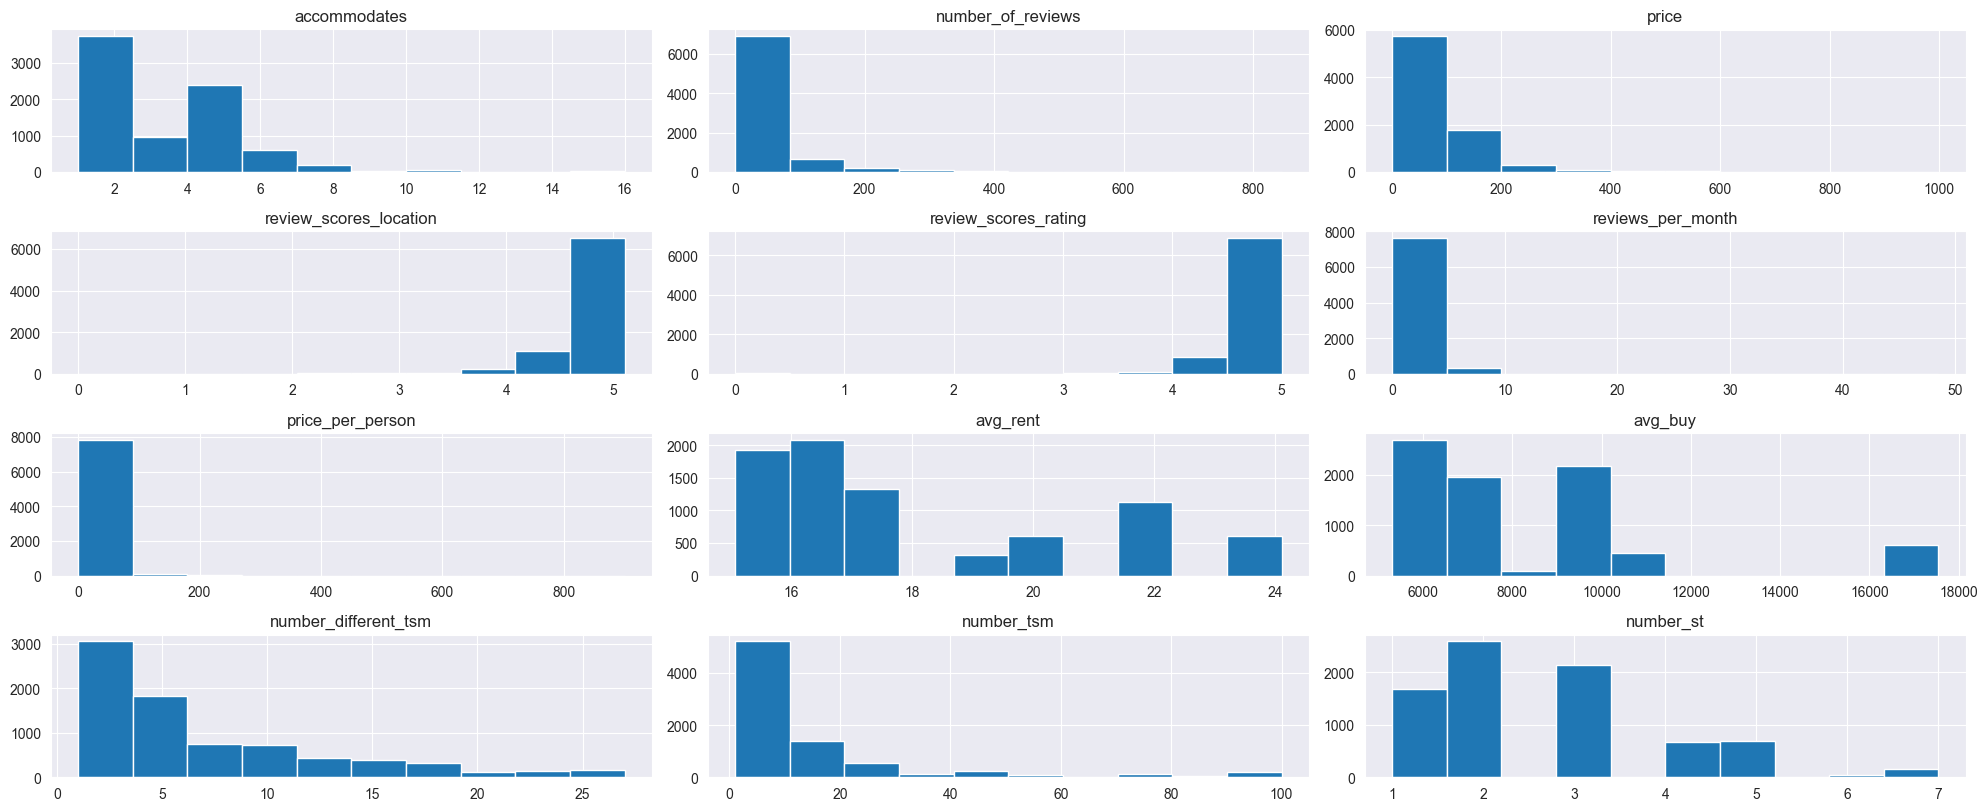

In [54]:
ax_list = relevant_features_df.hist(layout=(5,3), figsize=(20,10))
plt.tight_layout()

Now we take the a closer look at all the right or left skewed features, so we can log transform them, in the hope to get a more linear relationship with the `review_scores_location` variable.

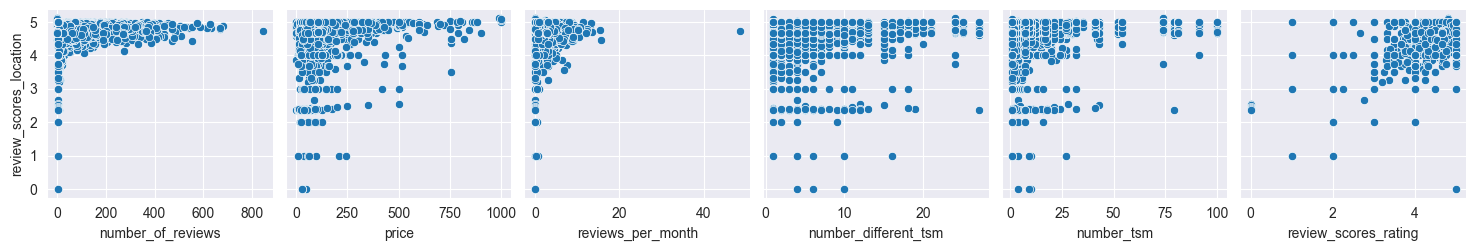

In [55]:
log_df = relevant_features_df[['review_scores_location', 'number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating']]
log_df = log_df.apply(np.log, axis=1)
log_df.review_scores_location = relevant_features_df.review_scores_location
sns.pairplot(relevant_features_df, y_vars=['review_scores_location'], x_vars=['number_of_reviews', 'price', 'reviews_per_month', 'number_different_tsm', 'number_tsm', 'review_scores_rating'])

After this data exploration, we fit a OLS to describe the relationship. We are using the `stats` version of it, as it allows a summary, that automatically performs significance tests, which give information whether to drop a variable for the model or not. We will use the 5\% significance level for dropping variables.

In [56]:
model = smf.ols(formula="review_scores_location ~ np.log(number_of_reviews, where=(number_of_reviews!=0)) +"
                        "np.log(price, where=(price!=0)) + "
                        "np.log(reviews_per_month) + np.log(number_different_tsm) +"
                        "np.log(number_tsm) + np.log(review_scores_rating, where=(review_scores_rating!=0)) + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                    -158.810
Model:                                OLS   Adj. R-squared:               -158.810
Method:                     Least Squares   F-statistic:                       nan
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):                nan
Time:                            13:08:08   Log-Likelihood:                -23693.
No. Observations:                    7967   AIC:                         4.739e+04
Df Residuals:                        7966   BIC:                         4.740e+04
Df Model:                               0                                         
Covariance Type:                nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: overflow encountered in square
  eigvals = self._wexog_singular_values ** 2
C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


The adjusted R-squared is really low of the model, therefore we try it without the log transformation.

In [57]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating + C(room_type) + "
                        "C(property_type) + number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.528
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     161.2
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:08:08   Log-Likelihood:                -487.29
No. Observations:                    7970   AIC:                             1087.
Df Residuals:                        7914   BIC:                             1478.
Df Model:                              55                                         
Covariance Type:                nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

We can see that the model has now a much higher adjusted R-squared. As all the categorical variables (`room_type` and `property_type`) are really insignificant we drop those.

In [58]:
model = smf.ols(formula="review_scores_location ~ number_of_reviews +"
                        "price + "
                        "reviews_per_month + number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "number_st + avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     881.7
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:08:08   Log-Likelihood:                -511.20
No. Observations:                    7970   AIC:                             1044.
Df Residuals:                        7959   BIC:                             1121.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

This dramatically decreased our model size, but the adj. R-squared is still the same. Now we drop the other insignificant variables:

In [59]:
model = smf.ols(formula="review_scores_location ~ "
                        "number_different_tsm +"
                        "number_tsm + review_scores_rating  + "
                        "avg_buy + avg_rent +"
                        "accommodates", data=relevant_features_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     review_scores_location   R-squared:                       0.526
Model:                                OLS   Adj. R-squared:                  0.525
Method:                     Least Squares   F-statistic:                     1470.
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                            13:08:08   Log-Likelihood:                -511.63
No. Observations:                    7970   AIC:                             1037.
Df Residuals:                        7963   BIC:                             1086.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

After dropping all the insignificant variables, we have received a small model that has the same adjusted R-squared as the biggest one. Now we check whether the model assumptions are even fulfilled.

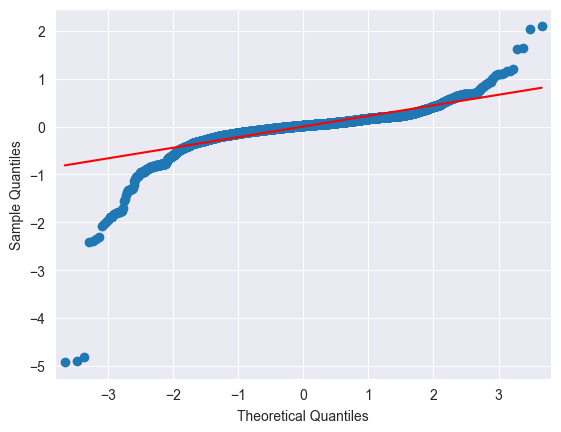

In [60]:
qq = sm.qqplot(model.resid, line='r')

The qq-plot does not look too great, because it has quite heavy tails. There are three points, that we need to check, because those are obviously outliers and we want to know whether they impact the model a lot.

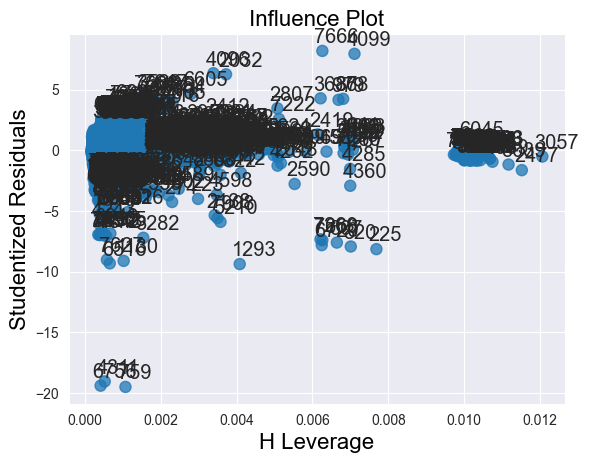

In [61]:
levfig = sm.graphics.influence_plot(model, size=8)

Using the influence plot, we can see that the three outliers before (those with really low studentized residuals) have close to zero impact on our model, so we can just leave them in. Now we can interpret the model:

Obviously, the most important factor that impacts the `review_scores_location` is the `review_scores_rating`, while the other ones have comparatively little impact, most of them even with negative coefficients. Interestingly enough, the number of different tourism points of interest has a positive impact, while the overall number of tourism points of interest has a negative one. The intercept is close to 2.5, which is what one would expect, the high `review_scores_location` are explained by the overall high ratings.

This concludes the answer to the question on how much impact points of interest and additional factors have on the location rating of an AirBnb.

The original goal was to predict the best location for a new AirBnb, if you are a host. One of the major factors is the expenses for an AirBnb at a certain location, this information sadly was not available. While one could get the average rent and buying prices per square metre, no information about typical sizes of AirBnbs in square metres per type (or number of accommodates) were available for free. Neither were typical operating costs per district (or more precise) available. Therefore, we followed the data science cycle and went back and looked for questions we could answer with all the data we were able to collect (and was generally available for free).

### Creation of train-test split

## Fitting best model

In this next section, we attempt to fit the best model to predict the location rating that does not use any information about the corresponding AirBnB. This includes the average rent and average buying price per square meter, the number of different tourism spots, the overall count of tourism spots and the number of public transport stations per grid. The reason for this approach is that we want to confirm that it is not only the choice of a simple linear regression model that caused the very poor performance and results on this dat set.

In [127]:
model_data_agg = model_data[["grid_id","review_scores_location","avg_rent","avg_buy","number_different_tsm","number_tsm","number_st"]]\
    .groupby(by = "grid_id").mean("review_scores_location").reset_index()

model_data_agg

,grid_id,review_scores_location,avg_rent,avg_buy,number_different_tsm,number_tsm,number_st
0,53.0,5.090599,16.940000,6646.130000,1.0,1.0,1.0
1,176.0,4.690288,16.940000,6646.130000,1.0,1.0,1.0
2,234.0,4.000000,17.150000,5962.340000,1.0,1.0,1.0
3,290.0,4.750000,15.830000,8201.800000,1.0,1.0,1.0
4,291.0,4.366000,16.940000,6646.130000,3.0,3.0,2.0
...,...,...,...,...,...,...,...
249,1541.0,4.741720,15.886667,6167.606667,1.0,1.0,4.0
250,1564.0,4.602000,16.720000,6668.690000,1.0,1.0,2.0
251,1590.0,4.674646,16.720000,6668.690000,1.0,1.0,2.0
252,1691.0,2.371555,16.720000,6668.690000,1.0,1.0,5.0


Here we just selected the relevant columns and aggregated the review scores for the location per grid cell.

In [90]:
train, test = train_test_split(model_data_agg,test_size=0.2,train_size =0.8, random_state=42)

Next, we created the train-test split for fitting and evaluating the different models later on. As our data set is quite small (254 rows), we are using an 80:20 split to still retain a decent size for the training data set.

In the following, we compared the results of four different models on this split using three different scaling methods each and two different evaluation metrics, which are listed below:

#### Scalers
- StandardScaler
- RobustScaler
- MinMaxScaler

#### models
- Linear Regression
- Lasso Regression
- SVM Regression with polynomial kernel
- Multilayer Perceptron

#### metrics
- RMSE
- R2

In [97]:
model_X_train = train.loc[:,train.columns != "review_scores_location"]
model_y_train = train["review_scores_location"]

model_X_test = test.loc[:,test.columns != "review_scores_location"]
model_y_test = test["review_scores_location"]

Here, we just separated the columns of the train and test set into explanatory and dependent variables.

In [119]:
def predict_pipeline(scaler, model, X_train, y_train,X_test):
    pipe = Pipeline([('scaler', scaler), ('svc', model)])
    pipe.fit(X_train,y_train)
    return pipe.predict(X_test)


def evaluate_model(y_true,y_pred):
    rmse = mean_squared_error(y_true,y_pred,squared=False)
    r2 = r2_score(y_true,y_pred)
    return  r2, rmse

The next step was to define some functions to facilitate the prediction and evaluation.

In [125]:
scalers = [StandardScaler(),MinMaxScaler(),RobustScaler()]
models = [SVR(kernel="poly"),Lasso(random_state=42),MLPRegressor(random_state=42),LinearRegression()]
result_rows = []


for scaler in scalers:
    for model in models:
        pred_temp = predict_pipeline(scaler,model,model_X_train,model_y_train,model_X_test)
        r2_tmp, rmse_tmp = evaluate_model(model_y_test,pred_temp)
        row = [scaler.__class__.__name__,model.__class__.__name__,r2_tmp,rmse_tmp]
        result_rows.append(row)

results_df = pd.DataFrame(result_rows,columns = ["scaler","model","r2","rmse"])


C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Anwender\Documents\UNI\DOPP\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


What we did here, was to iterate over all the models and scalers we wanted to compare and gather the evaluation metrics for the resulting predictions neatly in a data frame.

In [128]:
results_df

,scaler,model,r2,rmse
0,StandardScaler,SVR,-0.130894,0.180046
1,StandardScaler,Lasso,-0.139371,0.180720
2,StandardScaler,MLPRegressor,-9.318157,0.543843
3,StandardScaler,LinearRegression,-0.218051,0.186855
4,MinMaxScaler,SVR,0.014628,0.168063
5,MinMaxScaler,Lasso,-0.139371,0.180720
6,MinMaxScaler,MLPRegressor,-10.184255,0.566208
7,MinMaxScaler,LinearRegression,-0.218051,0.186855
8,RobustScaler,SVR,0.036234,0.166210
9,RobustScaler,Lasso,-0.139371,0.180720


When inspecting these results one can see that none of the models, no matter the scaling technique used seemed to be able to explain the variability in the review scores for the locations in any satisfactory way. One might be able to find better models by introducing more data sets on additional subjects, however, it is quite difficult to find such data sets that are freely available to use and would make sense in the context of this analysis.